# Linear Regression Model with PyTorch
### Mateusz Cedro

Implementation of Linear Regression Model from scratch with PyTorch


## 0. Import libraries

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Check PyTorch version
torch.__version__

'2.1.0+cu118'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


## 1. Data

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

In [5]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(6, 6))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

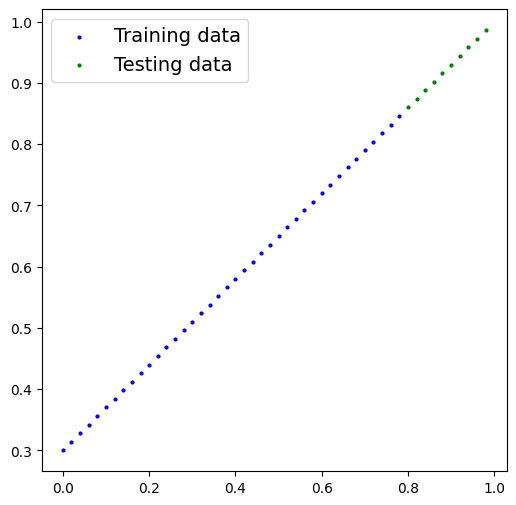

In [7]:
plot_predictions();

## 2. Build model
Linear regression model with Gradient Descent

In [8]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Using nn.Linear() to create a linear layer inside the model
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

    # Or by setting weights and biases
    # self.weights = nn.Parameter(torch.randn(1,
    #                                     requires_grad=True,
    #                                     dtype=torch.float))
    # self.bias = nn.Parameter(torch.randn(1,
    #                                      requires_grad=True,
    #                                      dtype=torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x) # return self.weights * x + self.bias

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the 'random' parameters
list(model_0.parameters())

[Parameter containing:
 tensor([[0.7645]], requires_grad=True),
 Parameter containing:
 tensor([0.8300], requires_grad=True)]

In [10]:
model_0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [11]:
weight, bias # hardcoded, desireable parameters

(0.7, 0.3)

## Make predictions with model

In [12]:
# y_preds = model_0(X_test) - contaions grad function

# with torch.no_grad():
#   y_preds = model_0(X_test)

with torch.inference_mode(): # turns off gradient tracking
  y_preds = model_0(X_test)

y_preds # predicted y's

tensor([[1.4416],
        [1.4569],
        [1.4722],
        [1.4875],
        [1.5028],
        [1.5181],
        [1.5334],
        [1.5487],
        [1.5640],
        [1.5793]])

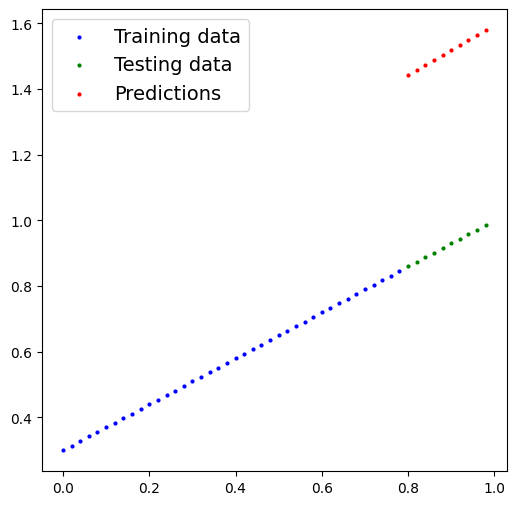

In [13]:
plot_predictions(predictions=y_preds)

Models predictions are there as good as random here because they were only initialized - not trained

## 3. Model training

* Training Loop - using Mean Absolute Error (MAE)
* Testing

In [14]:
# Steup a loss function
loss_fn = nn.L1Loss() # MAE

#Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                        lr=0.01)

### Building a training loop in PyTorch

In [15]:
model_0.to(device)
torch.manual_seed(42)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# Put the data on the target device - device agnostic code
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)



### Training
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode sets all parameters that require gradients to have gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss (input, target)
  loss = loss_fn(y_pred, y_train)

  # 3. Zero the gradients of the optimizer
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing
  with torch.inference_mode(): # turns off e.g. gradient tracking - torch.no_grad old style with gradient

    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if (epoch) % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")


print(f"\nSmallest test loss: {min(test_loss_values)}")

Epoch: 0 | Test: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Test: 0.4399680495262146 | Test loss: 0.4392663538455963
Epoch: 20 | Test: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Test: 0.20954827964305878 | Test loss: 0.16984674334526062
Epoch: 40 | Test: 0.09433844685554504 | Test loss: 0.03513689711689949
Epoch: 50 | Test: 0.023886386305093765 | Test loss: 0.04784906655550003
Epoch: 60 | Test: 0.0199567973613739 | Test loss: 0.04580312222242355
Epoch: 70 | Test: 0.016517987474799156 | Test loss: 0.0375305712223053
Epoch: 80 | Test: 0.013089170679450035 | Test loss: 0.029944902285933495
Epoch: 90 | Test: 0.009653178043663502 | Test loss: 0.02167237363755703

Smallest test loss: 0.02167237363755703


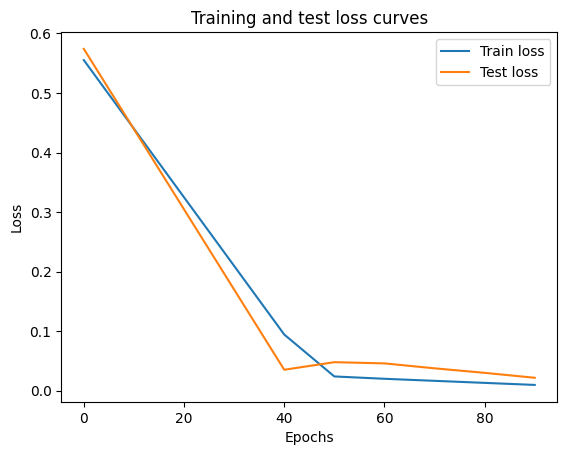

In [16]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [17]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
y_preds_new

tensor([[0.8483],
        [0.8617],
        [0.8750],
        [0.8884],
        [0.9018],
        [0.9152],
        [0.9286],
        [0.9420],
        [0.9553],
        [0.9687]])

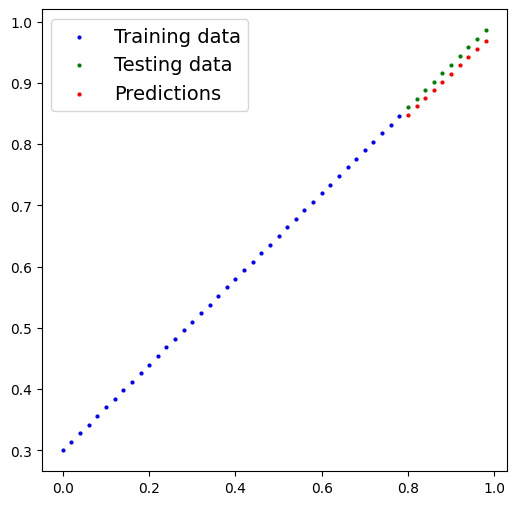

In [18]:
plot_predictions(predictions=y_preds_new.cpu())

In [19]:
model_0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]])),
             ('linear_layer.bias', tensor([0.3130]))])

## 4. Saving & loading the model

In [20]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "pytorch_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_model_0.pth


In [21]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_0.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [22]:
next(loaded_model_0.parameters()).device

device(type='cpu')

In [23]:
loaded_model_0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]])),
             ('linear_layer.bias', tensor([0.3130]))])

In [24]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_y_preds = loaded_model_0(X_test)

y_preds_new == loaded_y_preds # check whether predictions from loaded model are true

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Linear Regression Model implemented from scratch in PyTorch

### Mateusz Cedro